# STE Binary Network

In [2]:
# import torch base code
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from os import path
sys.path.append(path.join("..", "src"))
import torch_base
import matplotlib.pyplot as plt
import subprocess as sub

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Helper Functions**

In [3]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of output
    print(proc.stdout.read()) 
    
    return


"""
Function: mfccshow
    
    displays a tensor mfcc
    
        Args:
            mfcc (torch.Tensor) : image tensor (T, Freq)
            title (string)      : plot title
"""


def mfccshow(mfcc, title=''):

    # place image on CPU
    mfcc = mfcc.cpu()

    # plot MFCC
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(mfcc.transpose(0, 1))
    
    print("Mfcc Size (T, Freq) : {}".format(mfcc.size()))

    return

## Data Processing

Mfcc Size (T, Freq) : torch.Size([30, 39])


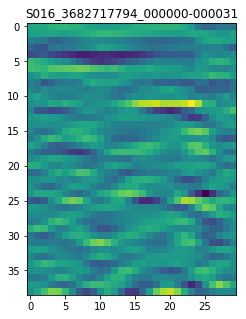

In [4]:
# imports
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from c_torch.process_data import MfccDataset, Numpy2Tensor, CropMfcc, mfcc_collate

train_dl = DataLoader(
    
    dataset=MfccDataset(
        '~/Music/suzero/english/test.dd.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
            CropMfcc(t=30, freq=39)
        ]),
        ret_keys=True
    ),
    
    batch_size=5,
    collate_fn=mfcc_collate,
    shuffle=True
)

keys, mfcc, seq_len = iter(train_dl).next()

# display MFCC
mfccshow(mfcc[0], title=keys[4])

Mfcc Size (T, Freq) : torch.Size([8, 39])


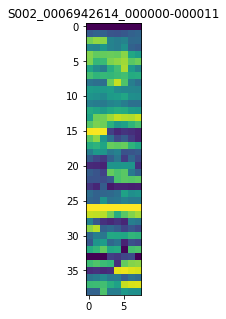

In [21]:
# imports
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch_base.process_data import MfccDataset, Numpy2Tensor, CropMfcc, mfcc_collate

train_dl = DataLoader(
    
    dataset=MfccDataset(
        '~/Music/suzero/english/output_feats.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
        ]),
        ret_keys=True
    ),
    
    batch_size=1,
    shuffle=False
)

keys, mfcc = iter(train_dl).next()

# display MFCC
mfccshow(mfcc[0], title=keys[0])

### Train

In [5]:
cmd = " ".join([
    "python /home/wintermute/Projects/suzerospeech2019/src/c_torch/train.py",
    "--sys",           "MfccAuto",
    "--epochs",           "20",
    "--gamma",            "0.1",
    "--learn_rate",       "0.001",
    "--log",              "~/Projects/suzerospeech2019/src/c_torch/networks/logs",
    "--train",            '~/Music/suzero/english/train.dd.npz',
    "--valid",            '~/Music/suzero/english/test.dd.npz',
    "--save",             "~/Projects/suzerospeech2019/src/c_torch/networks/logs",
    "--batch_size",       "100",
    "--bottleneck_depth", "100",
    "--mfcc_width",       "30",
    "--mfcc_height",      "39",
    "--verbose"   
])

run_cmd(cmd)

FileNotFoundError: [Errno 2] No such file or directory: 'python /home/wintermute/Projects/suzerospeech2019/src/c_torch/train.py --sys MfccAuto --epochs 20 --gamma 0.1 --learn_rate 0.001 --log ~/Projects/suzerospeech2019/src/c_torch/networks/logs --train ~/Music/suzero/english/train.dd.npz --valid ~/Music/suzero/english/test.dd.npz --save ~/Projects/suzerospeech2019/src/c_torch/networks/logs --batch_size 100 --bottleneck_depth 100 --mfcc_width 30 --mfcc_height 39 --verbose': 'python /home/wintermute/Projects/suzerospeech2019/src/c_torch/train.py --sys MfccAuto --epochs 20 --gamma 0.1 --learn_rate 0.001 --log ~/Projects/suzerospeech2019/src/c_torch/networks/logs --train ~/Music/suzero/english/train.dd.npz --valid ~/Music/suzero/english/test.dd.npz --save ~/Projects/suzerospeech2019/src/c_torch/networks/logs --batch_size 100 --bottleneck_depth 100 --mfcc_width 30 --mfcc_height 39 --verbose'

## MFCC Auto Network

In [8]:
from c_torch.networks import MfccAuto

mfcc_auto = MfccAuto(
    input_size=39, 
    bnd=4
)

# display Network
print(mfcc_auto.name)
print(mfcc_auto)

mfcc_auto.load("~/Projects/suzerospeech2019/src/c_torch/networks/logs/MfccAuto.pt")

MfccAuto
MfccAuto(
  (encoder): StackedRnnBase(
    (multilayer_rnn): ModuleList(
      (0): RNNBase(39, 20)
      (1): RNNBase(20, 60)
      (2): RNNBase(60, 4)
    )
  )
  (binarizer): Binarizer()
  (decoder): StackedRnnBase(
    (multilayer_rnn): ModuleList(
      (0): RNNBase(4, 120)
      (1): RNNBase(120, 60)
      (2): RNNBase(60, 20)
      (3): RNNBase(20, 39)
    )
  )
)


In [17]:
mfcc_hat, bits = mfcc_auto(mfcc, seq_len)
print(bits)

tensor([-1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
         1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
         1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,
         1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
        -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
         1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,
         1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
         1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
        -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -

Mfcc Size (T, Freq) : torch.Size([30, 39])


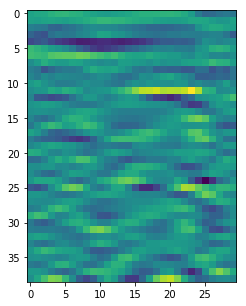

In [10]:
mfccshow(mfcc[0])

Mfcc Size (T, Freq) : torch.Size([30, 39])


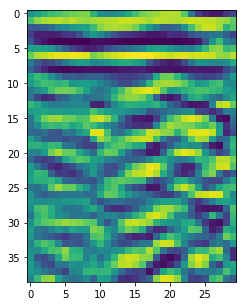

In [12]:
mfccshow(mfcc_hat[0].detach())

In [15]:
dataset=MfccDataset(
    '~/Music/suzero/english/test.dd.npz',
    transform=tf.Compose([
        Numpy2Tensor(),
        CropMfcc(t=30, freq=39)
    ])
)

In [16]:
for f in dataset:
    print(f.size())

torch.Size([8, 39])
torch.Size([19, 39])
torch.Size([17, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([16, 39])
torch.Size([11, 39])
torch.Size([20, 39])
torch.Size([24, 39])
torch.Size([17, 39])
torch.Size([15, 39])
torch.Size([25, 39])
torch.Size([27, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([18, 39])
torch.Size([22, 39])
torch.Size([18, 39])
torch.Size([10, 39])
torch.Size([22, 39])
torch.Size([14, 39])
torch.Size([18, 39])
torch.Size([28, 39])
torch.Size([14, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([28, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([25, 39])
torch.Size([12, 39])
torch.Size([18, 39])
torch.Size([12, 39])
torch.Size([20, 39])
torch.Size([16, 39])
torch.Size([15, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([15, 39])
torch.Size([14

torch.Size([22, 39])
torch.Size([18, 39])
torch.Size([22, 39])
torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([23, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([17, 39])
torch.Size([26, 39])
torch.Size([18, 39])
torch.Size([25, 39])
torch.Size([28, 39])
torch.Size([21, 39])
torch.Size([15, 39])
torch.Size([16, 39])
torch.Size([29, 39])
torch.Size([26, 39])
torch.Size([24, 39])
torch.Size([16, 39])
torch.Size([20, 39])
torch.Size([24, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([14, 39])
torch.Size([17, 39])
torch.Size([20, 39])
torch.Size([17, 39])
torch.Size([19, 39])
torch.Size([16, 39])
torch.Size([15, 39])
torch.Size([21, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([8, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([17

torch.Size([26, 39])
torch.Size([24, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([19, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([10, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([15, 39])
torch.Size([17, 39])
torch.Size([21, 39])
torch.Size([19, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([2

torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([22, 39])
torch.Size([24, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([14, 39])
torch.Size([16, 39])
torch.Size([12, 39])
torch.Size([24, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([20, 39])
torch.Size([21, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([26, 39])
torch.Size([25, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([21, 39])
torch.Size([28, 39])
torch.Size([12, 39])
torch.Size([22, 39])
torch.Size([27, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([2

torch.Size([10, 39])
torch.Size([12, 39])
torch.Size([20, 39])
torch.Size([24, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([15, 39])
torch.Size([20, 39])
torch.Size([15, 39])
torch.Size([12, 39])
torch.Size([19, 39])
torch.Size([27, 39])
torch.Size([12, 39])
torch.Size([9, 39])
torch.Size([14, 39])
torch.Size([22, 39])
torch.Size([24, 39])
torch.Size([22, 39])
torch.Size([8, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([15, 39])
torch.Size([24, 39])
torch.Size([13, 39])
torch.Size([12, 39])
torch.Size([19, 39])
torch.Size([14, 39])
torch.Size([19, 39])
torch.Size([24, 39])
torch.Size([28, 39])
torch.Size([21, 39])
torch.Size([16, 39])
torch.Size([12, 39])
torch.Size([15, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([18, 39])
torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([20, 39])
torch.Size([14, 39])
torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([21, 39])
torch.Size([8, 

torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([11, 39])
torch.Size([29, 39])
torch.Size([27, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([28, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([28, 39])
torch.Size([23, 39])
torch.Size([25, 39])
torch.Size([24, 39])
torch.Size([27, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([3

torch.Size([25, 39])
torch.Size([24, 39])
torch.Size([19, 39])
torch.Size([23, 39])
torch.Size([17, 39])
torch.Size([18, 39])
torch.Size([16, 39])
torch.Size([18, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([19, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([15, 39])
torch.Size([16, 39])
torch.Size([16, 39])
torch.Size([21, 39])
torch.Size([15, 39])
torch.Size([24, 39])
torch.Size([13, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([23, 39])
torch.Size([16, 39])
torch.Size([23, 39])
torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([9, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([20, 39])
torch.Size([29, 39])
torch.Size([21, 39])
torch.Size([27, 39])
torch.Size([10, 39])
torch.Size([22, 39])
torch.Size([28, 39])
torch.Size([24, 39])
torch.Size([12, 39])
torch.Size([10, 39])
torch.Size([19, 39])
torch.Size([30

torch.Size([22, 39])
torch.Size([23, 39])
torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([16, 39])
torch.Size([26, 39])
torch.Size([27, 39])
torch.Size([21, 39])
torch.Size([14, 39])
torch.Size([25, 39])
torch.Size([25, 39])
torch.Size([20, 39])
torch.Size([22, 39])
torch.Size([16, 39])
torch.Size([17, 39])
torch.Size([22, 39])
torch.Size([12, 39])
torch.Size([19, 39])
torch.Size([15, 39])
torch.Size([28, 39])
torch.Size([19, 39])
torch.Size([17, 39])
torch.Size([18, 39])
torch.Size([17, 39])
torch.Size([20, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([13, 39])
torch.Size([26, 39])
torch.Size([24, 39])
torch.Size([24, 39])
torch.Size([16, 39])
torch.Size([14, 39])
torch.Size([22, 39])
torch.Size([23, 39])
torch.Size([19, 39])
torch.Size([25, 39])
torch.Size([16, 39])
torch.Size([11, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([18, 39])
torch.Size([2

torch.Size([19, 39])
torch.Size([20, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([13, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([18, 39])
torch.Size([17, 39])
torch.Size([24, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([16, 39])
torch.Size([24, 39])
torch.Size([28, 39])
torch.Size([22, 39])
torch.Size([21, 39])
torch.Size([11, 39])
torch.Size([25, 39])
torch.Size([21, 39])
torch.Size([13, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([21, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([12, 39])
torch.Size([24, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([18, 39])
torch.Size([21, 39])
torch.Size([16, 39])
torch.Size([14, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([13, 39])
torch.Size([24, 39])
torch.Size([2

torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([24, 39])
torch.Size([14, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([24, 39])
torch.Size([21, 39])
torch.Size([22, 39])
torch.Size([17, 39])
torch.Size([14, 39])
torch.Size([20, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([27, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([25, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([11, 39])
torch.Size([18, 39])
torch.Size([26, 39])
torch.Size([17, 39])
torch.Size([18, 39])
torch.Size([22, 39])
torch.Size([13, 39])
torch.Size([24, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([1

torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([15, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([17, 39])
torch.Size([27, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([22, 39])
torch.Size([26, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([24, 39])
torch.Size([1

torch.Size([21, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([29, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([21, 39])
torch.Size([23, 39])
torch.Size([27, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([17, 39])
torch.Size([26, 39])
torch.Size([2

torch.Size([20, 39])
torch.Size([25, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([12, 39])
torch.Size([13, 39])
torch.Size([8, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([29, 39])
torch.Size([22, 39])
torch.Size([29, 39])
torch.Size([13, 39])
torch.Size([14, 39])
torch.Size([17, 39])
torch.Size([17, 39])
torch.Size([18, 39])
torch.Size([28, 39])
torch.Size([13, 39])
torch.Size([15, 39])
torch.Size([12, 39])
torch.Size([18, 39])
torch.Size([28, 39])
torch.Size([12, 39])
torch.Size([25, 39])
torch.Size([8, 39])
torch.Size([15, 39])
torch.Size([21, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([10, 39])
torch.Size([15, 39])
torch.Size([27, 39])
torch.Size([15, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([13, 39])
torch.Size([19, 39])
torch.Size([20, 39])
torch.Size([28,

torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([24, 39])
torch.Size([19, 39])
torch.Size([24, 39])
torch.Size([16, 39])
torch.Size([20, 39])
torch.Size([17, 39])
torch.Size([17, 39])
torch.Size([16, 39])
torch.Size([20, 39])
torch.Size([20, 39])
torch.Size([11, 39])
torch.Size([24, 39])
torch.Size([9, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([14, 39])
torch.Size([14, 39])
torch.Size([10, 39])
torch.Size([11, 39])
torch.Size([9, 39])
torch.Size([15, 39])
torch.Size([18, 39])
torch.Size([15, 39])
torch.Size([22, 39])
torch.Size([9, 39])
torch.Size([10, 39])
torch.Size([12, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([19, 39])
torch.Size([13, 39])
torch.Size([20, 39])
torch.Size([29, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([15, 39])
torch.Size([24, 

torch.Size([29, 39])
torch.Size([12, 39])
torch.Size([8, 39])
torch.Size([13, 39])
torch.Size([17, 39])
torch.Size([10, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([23, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([19, 39])
torch.Size([17, 39])
torch.Size([18, 39])
torch.Size([18, 39])
torch.Size([20, 39])
torch.Size([22, 39])
torch.Size([21, 39])
torch.Size([22, 39])
torch.Size([22, 39])
torch.Size([20, 39])
torch.Size([14, 39])
torch.Size([19, 39])
torch.Size([18, 39])
torch.Size([12, 39])
torch.Size([19, 39])
torch.Size([27, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([23, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([28, 39])
torch.Size([14, 39])
torch.Size([12, 39])
torch.Size([30

torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([11, 39])
torch.Size([19, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([24, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([16, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([21, 39])
torch.Size([17, 39])
torch.Size([20, 39])
torch.Size([17, 39])
torch.Size([20, 39])
torch.Size([12, 39])
torch.Size([10, 39])
torch.Size([21, 39])
torch.Size([25, 39])
torch.Size([20, 39])
torch.Size([25, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([8, 39])
torch.Size([15, 39])
torch.Size([18, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30

torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([27, 39])
torch.Size([26, 39])
torch.Size([26, 39])
torch.Size([25, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([16, 39])
torch.Size([28, 39])
torch.Size([19, 39])
torch.Size([16, 39])
torch.Size([14, 39])
torch.Size([15, 39])
torch.Size([23, 39])
torch.Size([26, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([24, 39])
torch.Size([11, 39])
torch.Size([1

torch.Size([21, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([16, 39])
torch.Size([12, 39])
torch.Size([19, 39])
torch.Size([12, 39])
torch.Size([9, 39])
torch.Size([20, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([26, 39])
torch.Size([18, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([26, 39])
torch.Size([10, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([14, 39])
torch.Size([16, 39])
torch.Size([28, 39])
torch.Size([21, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([11, 39])
torch.Size([14, 39])
torch.Size([19, 39])
torch.Size([25, 39])
torch.Size([16, 39])
torch.Size([15, 39])
torch.Size([18, 39])
torch.Size([23, 39])
torch.Size([14, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([27, 39])
torch.Size([30, 39])
torch.Size([28

torch.Size([19, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([14, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([15, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([10, 39])
torch.Size([22, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([15, 39])
torch.Size([11, 39])
torch.Size([17, 39])
torch.Size([29, 39])
torch.Size([22, 39])
torch.Size([26, 39])
torch.Size([10, 39])
torch.Size([18, 39])
torch.Size([14, 39])
torch.Size([21, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([13, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([11, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([21, 39])
torch.Size([25, 39])
torch.Size([17, 39])
torch.Size([21, 39])
torch.Size([29, 39])
torch.Size([2

torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([16, 39])
torch.Size([21, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([18, 39])
torch.Size([25, 39])
torch.Size([11, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([17, 39])
torch.Size([16, 39])
torch.Size([24, 39])
torch.Size([9, 39])
torch.Size([10, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([14, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([17, 39])
torch.Size([24, 39])
torch.Size([26, 39])
torch.Size([16, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([12, 39])
torch.Size([15, 39])
torch.Size([19, 39])
torch.Size([9, 39])
torch.Size([18, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([16,

torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([28, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([24, 39])
torch.Size([16, 39])
torch.Size([15, 39])
torch.Size([8, 39])
torch.Size([13, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([11, 39])
torch.Size([10, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([8, 39])
torch.Size([13, 39])
torch.Size([17, 39])
torch.Size([16, 39])
torch.Size([17, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([15, 39])
torch.Size([18, 39])
torch.Size([15, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([10, 39])
torch.Size([23, 39])
torch.Size([15,

torch.Size([8, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([12, 39])
torch.Size([17, 39])
torch.Size([17, 39])
torch.Size([15, 39])
torch.Size([15, 39])
torch.Size([8, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([13, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([23, 39])
torch.Size([18, 39])
torch.Size([11, 39])
torch.Size([24, 39])
torch.Size([10, 39])
torch.Size([18, 39])
torch.Size([15, 39])
torch.Size([26, 39])
torch.Size([21, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([12, 39])
torch.Size([16, 39])
torch.Size([12, 39])
torch.Size([23, 39])
torch.Size([10, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([29,

torch.Size([18, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([15, 39])
torch.Size([16, 39])
torch.Size([20, 39])
torch.Size([21, 39])
torch.Size([20, 39])
torch.Size([28, 39])
torch.Size([23, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([24, 39])
torch.Size([24, 39])
torch.Size([18, 39])
torch.Size([25, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([27, 39])
torch.Size([21, 39])
torch.Size([21, 39])
torch.Size([18, 39])
torch.Size([21, 39])
torch.Size([26, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([28, 39])
torch.Size([16, 39])
torch.Size([18, 39])
torch.Size([21, 39])
torch.Size([11, 39])
torch.Size([21, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([9, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([19

torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([17, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([25, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([13, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([24, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([20, 39])
torch.Size([11, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([2

torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([27, 39])
torch.Size([20, 39])
torch.Size([29, 39])
torch.Size([22, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([29, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([25, 39])
torch.Size([30, 39])
torch.Size([22, 39])
torch.Size([25, 39])
torch.Size([22, 39])
torch.Size([10, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([21, 39])
torch.Size([26, 39])
torch.Size([18, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([23, 39])
torch.Size([15, 39])
torch.Size([29, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([23, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([25, 39])
torch.Size([19, 39])
torch.Size([22, 39])
torch.Size([26, 39])
torch.Size([19, 39])
torch.Size([3

torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([21, 39])
torch.Size([23, 39])
torch.Size([22, 39])
torch.Size([17, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([10, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([29, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([19, 39])
torch.Size([15, 39])
torch.Size([21, 39])
torch.Size([24, 39])
torch.Size([25, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([21, 39])
torch.Size([30, 39])
torch.Size([27, 39])
torch.Size([12, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([12, 39])
torch.Size([25, 39])
torch.Size([25, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([30, 39])
torch.Size([20, 39])
torch.Size([21, 39])
torch.Size([3

torch.Size([28, 39])
torch.Size([30, 39])
torch.Size([8, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([14, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([16, 39])
torch.Size([19, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([15, 39])
torch.Size([30, 39])
torch.Size([19, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([16, 39])
torch.Size([26, 39])
torch.Size([22, 39])
torch.Size([24, 39])
torch.Size([14, 39])
torch.Size([15, 39])
torch.Size([22, 39])
torch.Size([16, 39])
torch.Size([25, 39])
torch.Size([23, 39])
torch.Size([26, 39])
torch.Size([30, 39])
torch.Size([15, 39])
torch.Size([21, 39])
torch.Size([28, 39])
torch.Size([21, 39])
torch.Size([20, 39])
torch.Size([19, 39])
torch.Size([25, 39])
torch.Size([20, 39])
torch.Size([30, 39])
torch.Size([10, 39])
torch.Size([30, 39])
torch.Size([28, 39])
torch.Size([18, 39])
torch.Size([30, 39])
torch.Size([23

torch.Size([23, 39])
torch.Size([27, 39])
torch.Size([13, 39])
torch.Size([18, 39])
torch.Size([29, 39])
torch.Size([21, 39])
torch.Size([14, 39])
torch.Size([30, 39])
torch.Size([16, 39])
torch.Size([30, 39])
torch.Size([24, 39])
torch.Size([23, 39])
torch.Size([23, 39])
torch.Size([23, 39])
torch.Size([9, 39])
torch.Size([30, 39])
torch.Size([13, 39])
torch.Size([10, 39])
torch.Size([15, 39])
torch.Size([17, 39])
torch.Size([15, 39])
torch.Size([17, 39])
torch.Size([15, 39])
torch.Size([14, 39])
torch.Size([24, 39])
torch.Size([8, 39])
torch.Size([30, 39])
torch.Size([18, 39])
torch.Size([27, 39])
torch.Size([26, 39])
torch.Size([24, 39])
torch.Size([11, 39])
torch.Size([14, 39])
torch.Size([21, 39])
torch.Size([25, 39])
torch.Size([17, 39])
torch.Size([16, 39])
torch.Size([14, 39])
torch.Size([13, 39])
torch.Size([30, 39])
torch.Size([29, 39])
torch.Size([11, 39])
torch.Size([30, 39])
torch.Size([26, 39])
torch.Size([25, 39])
torch.Size([30, 39])
